# 0.0 Modules, etc.

In [ ]:
import numpy as np
import pandas as pd
import multiprocessing

import scipy
from scipy import spatial
from scipy.spatial import cKDTree

import sklearn as sk
from sklearn import svm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import clone
from sklearn.externals.six.moves import xrange

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

In [ ]:
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

In [ ]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
# plotly.tools.set_credentials_file(username='duplinskiy', api_key='RsZHhxIiAGGu7FN9P4bu')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

cf.go_offline()

# 1 Preprocessing

## 1.1 Wrangling

In [ ]:
%%time
dat0 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

# len(dat0['article_number'].unique()) # 46573

dat = dat0.copy()

dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names

dat = dat[dat['gross_demand_quantity'] != 0] 

Data

    (0) dat0
    (1) dat

In [ ]:
# Feature subset for clustering
dat = dat[['article_number', 
           'gross_demand_quantity', # mean, sum, std
           'fraction_of_full_price', # mean, std
           'markdown', # mean (INDICATOR) 
           'sale', # mean (INDICATOR no/sale)
           'gross_sales_net_disc_gross_ret']]

dat['sales_price'] = dat['gross_sales_net_disc_gross_ret'].divide(dat['gross_demand_quantity'])
dat.drop('gross_sales_net_disc_gross_ret', axis = 1, inplace = True)

In [ ]:
%%time

dat_grouped = dat.groupby(by = 'article_number')

dat = dat_grouped.agg(['mean', 'std']) # Need count
dat.drop([('markdown', 'std'),('sale', 'std')], axis = 1, inplace=True)
dat[('gross_demand_quantity','sum')] = dat_grouped['gross_demand_quantity'].sum()

dat.fillna(value=0, inplace = True) # Define single transaction article std to be 0
dat = dat.replace([np.inf, -np.inf, np.nan], 0)

## 1.2 Save/Load curated data

In [ ]:
# Save/load tidied version

# dat.to_csv('dat.csv')

dat = pd.read_csv('dat.csv', low_memory=False, index_col = 0, header = [0,1]) # gotta encode multi-index

Datasets:

    (0) dat0
    (1) dat
    (2) dat_feature_sorted

## 1.3 Principal Component Analysis (for 2-D visualizations)

In [ ]:
%%time

# SCALING: zero mean and unit variance 
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(dat)
# dat_scaled = scaler.transform(dat)

# PRINCIPAL COMPONENT ANALYSIS
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # keep the first two principal components of the data
pca.fit(dat)

# transform data onto the first two principal components
dat_pca = pca.transform(dat)

# EDA 
np.isnan(np.log(dat_pca[:,0])).sum()
(dat_pca[:,1] < 0).sum()
(pd.DataFrame(dat_pca)).describe()

# 2 Clustering (aka classification, segmentation)

## 2.0 Baseline: feature-based

### 2.0.1 Sort

In [ ]:
feature = 'sales_price'
stat = 'mean'

dat_feature_sorted = dat.sort_values([(feature, stat)], ascending=False) # Sort

# Feature cumulative sum
dat_feature_sorted['cumulative_feature'] = dat_feature_sorted[feature][stat].cumsum()

# Feature cumulative percent
total = dat_feature_sorted[feature][stat].sum() 
dat_feature_sorted['cumulative_pct_feature'] = dat_feature_sorted[feature][stat].cumsum()/total

# Cumulative percent of articles
t = pd.Series(range(1, 46573))/46572
dat_feature_sorted['cumulative_pct_articles'] = t.values

In [ ]:
# Add feature based cluster; i.e. top X are labelled non-basic
dat_feature_sorted['feat_based'] = np.concatenate([np.ones(8483), np.zeros(38089)]) # match ____ counts below

dat_feature_sorted['feat_based'].value_counts() 

f = pd.DataFrame(dat_feature_sorted['feat_based'])

Datasets:

    (0) dat0
    (1) dat
    (2) dat_feature_sorted
        - f


### 2.0.2 Plot

In [ ]:
plt.plot(dat_feature_sorted['cumulative_pct_articles'], 
         dat_feature_sorted['cumulative_pct_feature'],
        linewidth = 3)

# plt.xlabel('Percent of Articles')
# plt.ylabel('Percent of Feature of Interst')

plt.rcParams["figure.figsize"] = [6,6]
plt.title('Majority, from a Minority of Articles')

In [ ]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = dat_feature_sorted['cumulative_pct_articles'],
    y = dat_feature_sorted['cumulative_pct_feature'],
    mode = 'lines',
    name = '45 degree line'
)


data = [trace1]
iplot(data, filename='scatter-mode')

## 2.01 Scale features

In [ ]:
# SCALING: zero mean and unit variance 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dat)
dat_scaled = pd.DataFrame(scaler.transform(dat), columns = dat.columns, index = dat.index)

Datasets:

    (0) dat0
    (1) dat
    (2) dat_feature_sorted
        - f
    (3) dat_scaled

## 2.1 k-means

### 2.1.1 Model

In [ ]:
%%time

# K-means clustering  --------------------  --------------------
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
kmeans.fit(dat_scaled)

Kmeans = pd.Series(kmeans.predict(dat_scaled)) # Cluster assignments

# Cluster counts
print(Kmeans.value_counts())
print()

In [ ]:
Kmeans = (Kmeans != 0)*1 # lone vector
Kmeans.value_counts()

# k = pd.DataFrame({'kmeans': Kmeans.values}, index = dat_scaled.index)


### 2.1.2 Plots

In [ ]:
import matplotlib as mpl

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
pd.plotting.scatter_matrix(
    dat[[
        ('gross_demand_quantity', 'mean'), 
        ('gross_demand_quantity', 'std'),
        ('sales_price', 'mean'), 
        ('gross_demand_quantity', 'sum')
        ]], 
    figsize=(10,10),
    diagonal='kde',
    c = Kmeans, 
    alpha = 0.5
)

In [ ]:
plt.subplot(2, 1, 1)
plt.scatter(dat['gross_demand_quantity']['mean'], 
            dat['sales_price']['mean'], 
            c = Kmeans,
            alpha = 0.5)
plt.title('Sale Price vs. Gross Demand Quantity')
plt.ylabel('Sale Price')

plt.subplot(2, 1, 2)
plt.scatter(dat['gross_demand_quantity']['sum'], 
            dat['sales_price']['mean'], 
            c = Kmeans,
            alpha = 0.5)
# plt.title('Sale Price vs. Gross Demand Qty (mean/sum)')
plt.ylabel('Sale Price')
plt.xlabel('GDQ Sum')

# plt.xlabel('Sales Price')
# plt.ylabel('log(sold_qty)')

# plt.colorbar()
# plt.rcParams["figure.figsize"] = [5,5]
# plt.title('K-means Classification')


### 2.1.3 Histograms

#### (a) gross_demand_quantity - basic

In [ ]:
# Histogram: total gross demand quantity, basic items
dat[(dat['Kmeans'] == 0) & (dat['gross_demand_quantity']['sum'] < 10000)]['gross_demand_quantity']['sum'].hist(
    bins = 100, 
)

plt.xlabel('Total Gross Demand Quantity')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Basic Articles')

#### (b) gross_demand_quantity - non-basic

In [ ]:
# Histogram: total gross_demand_quantity, non-basic items
dat[(dat['Kmeans'] != 0) & (dat['gross_demand_quantity']['sum'] < 5000)]['gross_demand_quantity']['sum'].hist(bins = 50)

plt.xlabel('Total Gross Demand Quantity')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Non-basic Articles')


#### (c) sales_price - basic

In [ ]:
# Histogram: sales_price, basic items
dat[(dat['Kmeans'] == 0) & (dat['sales_price']['mean'] < 200) & (dat['sales_price']['mean'] > 0)]['sales_price']['mean'].hist(bins = 100)

plt.xlabel('Sale Price')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Basic Articles')


#### (d) sales_price - non-basic

In [ ]:
# Histogram: sales_price, non-basic items
dat[(dat['Kmeans'] != 0) & (dat['sales_price']['mean'] < 200)]['sales_price']['mean'].hist(bins = 100)

plt.xlabel('Sale Price')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Non-basic Articles')

## 2.2 Agglomerative Clustering

In [ ]:
%%time

# Agglomerative Clustering -------------
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters = 6)
agglom = pd.Series(agg.fit_predict(dat_scaled))

agglom.value_counts()

In [ ]:
# # Reclassify: majority/non as 0/1 

agglom = (agglom != 0)*1 # lone vector
agglom.value_counts()

In [ ]:
a = pd.DataFrame({'agglom': agglom.values}, index = dat_scaled.index)

Datasets:

    (0) dat0
    (1) dat
    (2) dat_feature_sorted
        - f
    (3) dat_scaled
        - k
        - a

In [ ]:
plt.subplot(2, 1, 1)
plt.scatter(dat_scaled['gross_demand_quantity']['mean'], 
            dat_scaled['sales_price']['mean'], 
            c = agglom,
            alpha = 0.25)
plt.title('Agglomerative Classes: Sale Price vs. Gross Demand Qty (mean/sum)')
plt.ylabel('Sale Price')

plt.subplot(2, 1, 2)
plt.scatter(dat_scaled['gross_demand_quantity']['sum'], 
            dat_scaled['sales_price']['mean'], 
            c = agglom,
            alpha = 0.25)
plt.ylabel('Sale Price')
plt.xlabel('GDQ Sum')


## 2.3 DBSCAN 

'density based spatial clustering of applications with noise'

In [ ]:
%%time

from sklearn.cluster import DBSCAN

dbscan = DBSCAN() # 3min 36s
dbs = pd.Series(dbscan.fit_predict(dat_scaled))

dbs.value_counts()

In [ ]:
# # Reclassify: majority/non as 0/1 
dbs01 = (dbs != -1)*1 # lone vector
dbs01.value_counts()

In [ ]:
dbs = pd.DataFrame({'dbs': dbs01.values}, index = dat_scaled.index)

Datasets:

    (0) dat0
    (1) dat
    (2) dat_feature_sorted
        - f
    (3) dat_scaled
        - k
        - a
        - dbs

In [ ]:
plt.scatter(np.log(dat['net_sales']['sum']), 
            np.log(dat['sold_qty']['sum']), 
            c = dbs01,
            alpha = 0.15)
plt.xlabel('log(net_sales)')
plt.ylabel('log(sold_qty)')
plt.colorbar()
plt.title('DBSCAN Classification')
plt.rcParams["figure.figsize"] = [16,16]

## 2.4 Evaluation

### 2.4.1 Cross methods comparison

In [ ]:
# k_a = pd.merge(k, a, left_index = True, right_index = True)

# f_k_a = pd.merge(f, k_a, left_index=True, right_index=True)

# fka_dbs = pd.merge(f_k_a, dbs, left_index=True, right_index=True)

In [ ]:
.groupby(['feat_based', 'kmeans', 'agglom']).size()

table = pd.DataFrame(data = {'Ag': agglom, 'Km': Kmeans, 'DB': dbs01})
table.groupby(['Ag', 'Km', 'DB']).size()
1 - 3924/46573 # 0.9157 kmeans-agglomerative agreement


Datasets:

    (0) dat0
    (1) dat
    (2) dat_feature_sorted
        - f
    (3) dat_scaled
        - k
        - a
        - dbs
    (4) table

### 2.4.2 Clustering Metrics

See https://scikit-learn.org/stable/modules/clustering.html for metric information (2.4.2 - __ )

In [ ]:
dat_feature_sorted_scaled = pd.DataFrame(StandardScaler().fit(dat_feature_sorted).transform(dat_feature_sorted), 
                                         columns = dat_feature_sorted.columns,
                                         index = dat_feature_sorted.index)


Datasets:

    (0) dat0
    (1) dat
    (2) dat_feature_sorted
        - f
    (3) dat_scaled
        - k
        - a
        - dbs
    (4) table
    (5) dat_feature_sorted_scaled

#### Silhouette Coefficient

In [ ]:
from sklearn import metrics

# higher better

metrics.silhouette_score(dat_feature_sorted_scaled, f['feat_based']) # feature based: 0.555

metrics.silhouette_score(dat_feature_sorted, f['feat_based']) # feature based: 0.59568
metrics.silhouette_score(dat_scaled, k['kmeans']) # k-means: 0.44598
metrics.silhouette_score(dat_scaled, a['agglom']) # agglomerative: 0.33

#### Calinski-Harabaz Index

In [ ]:
# higher better

metrics.calinski_harabaz_score(dat_feature_sorted_scaled, f['feat_based']) # 20816

metrics.calinski_harabaz_score(dat_feature_sorted, f['feat_based']) # 77433
metrics.calinski_harabaz_score(dat_scaled, k['kmeans']) # 7474
metrics.calinski_harabaz_score(dat_scaled, a['agglom']) # 5147


#### Davies-Bouldin Index

In [ ]:
# lower is better

metrics.davies_bouldin_score(dat_feature_sorted_scaled, f['feat_based']) # 0.779

metrics.davies_bouldin_score(dat_feature_sorted, f['feat_based']) # 0.44
metrics.davies_bouldin_score(dat_scaled, k['kmeans']) # 1.186
metrics.davies_bouldin_score(dat_scaled, a['agglom']) # 1.47


# 3 Article Reference Data

In [ ]:
dat2 = pd.read_csv('article_reference_data_y2016_18.csv',
                 delimiter = '~',
                  low_memory = False,
                   usecols=['group_article', 'brand', 'sub_brand', 'season_create', 'season_active',
                            'graphic', 'gender', 'age_group', 'retail_intro_date_global',
                            'retail_exit_date_global', 'material_technology', 'pictogram_composition',
                            'price_band', 'gender_age', 'construction_type', 'length_mes_uom_dim',
                            'uom_dim', 'height_mes_uom_dim', 'width_mes_uom_dim', 'article_descr',
                            'drop_season', 'uom_vol', 'uom_wgt', 'product_fit', 'material_way_type',
                            'outer_sole_main_material', 'inner_sole_main_material', 'main_material_lining',
                            'main_material_upper', 'dimension_uov', 'dimension_uom', 'carried_over_from',
                            'drop_date', 'retail_exit_tgt_season', 'product_franchise', 'age_group_descr',
                            'brand_descr', 'sub_brand_descr', 'lifecylce_status_prod_descr', 'brand_asset_descr',
                            'rmh_retail_class_descr', 'rmh_retail_department_descr', 'rmh_retail_sub_class_descr',
                            'rmh_retail_sub_dept_descr', 'rmh_category_descr', 'rmh_gender_descr',
                            'rmh_retail_section_descr', 'rmh_product_division_descr', 'rmh_product_type_descr',
                            'spm_color_first_descr', 'spm_color_second_descr', 'spm_color_third_descr',
                            'spm_color_fourth_descr', 'product_franchise_descr'
                           ]
                  )

In [ ]:
# dat2['<feature>'].unique()
# len(dat2['<feature'].unique())

# Yes (11)
# ['rmh_product_type_descr', 'rmh_product_division_descr', 'rmh_retail_section_descr',
# 'rmh_gender_descr', 'rmh_category_descr', 'rmh_retail_department_descr',
# 'sub_brand_descr', 'brand_descr', 'age_group_descr', 'age_group', 'gender']

# No (13)
# 'graphic', 'pictogram_composition', 'article_descr', 'lifecylce_status_prod_descr', 'brand_asset_descr', 
# 'rmh_retail_class_descr', 'rmh_retail_sub_class_descr', 'rmh_retail_sub_dept_descr', 'spm_color_first_descr', 
# 'spm_color_second_descr', 'spm_color_third_descr','spm_color_fourth_descr', 'product_franchise_descr' 


dat2.drop(['uom_dim', 'drop_season', 'uom_vol', 'uom_wgt', 'material_way_type', 'inner_sole_main_material', 
           'main_material_upper', 'outer_sole_main_material', 'main_material_lining', 'carried_over_from', 'drop_date',
           'graphic', 'pictogram_composition', 'article_descr', 'lifecylce_status_prod_descr', 'brand_asset_descr', 
           'rmh_retail_class_descr', 'rmh_retail_sub_class_descr', 'rmh_retail_sub_dept_descr', 'spm_color_first_descr', 
           'spm_color_second_descr', 'spm_color_third_descr','spm_color_fourth_descr', 'product_franchise_descr' 
          ], axis = 1, inplace=True)


In [ ]:
# Save/read data

# dat2.to_csv('dat2.csv')

dat2 = pd.read_csv('dat2.csv', low_memory=False, index_col = 0) 

In [ ]:
# pd.to_datetime(dat2['season_create'])

dat2.dtypes

{print(x, '-->', len(dat2[x].unique())) for x in dat2.columns}

Datasets:

    (0) dat0
    (1) dat
    (2) dat_feature_sorted
        - f
    (3) dat_scaled
        - k
        - a
        - dbs
    (4) table
    (5) dat_feature_sorted_scaled
    (6) dat2

# 4 Cluster Prediction

    *Pause this for now, determine if clustering helps

### 4.0.2 Scaling

In [ ]:
# Standardize non-numeric features

# dt = pd.DataFrame(data = dat2.dtypes, columns = ['type'])
# num = dt[(dt['type'] == 'int64') | (dt['type'] == 'float64')].index
# obj = dt[(dt['type'] != 'int64') & (dt['type'] != 'float64')].index

# dat2_num = dat2[num]

# scaler = StandardScaler()
# scaler.fit(dat2_num)

# dat2_num_scaled = pd.DataFrame(scaler.transform(dat2_num), columns = dat2_num.columns, index = dat2_num.index)
# dat2_num_scaled.head()

### 4.0.3 One-hot Encoding

In [ ]:
%%time

dat2_dummy = pd.get_dummies(dat2)

dat2_dummy.shape

## 4.1 Classification Models

### 4.1.1 Train-Test Split

In [ ]:
X = dat2_dummy.drop('Kmeans', axis = 1)
y = dat2_dummy['Kmeans']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### 4.1.2 Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X, y)

tree.score(X_train, y_train)
tree.score(X_test, y_test)

### 4.1.3 Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:

mlp = MLPClassifier().fit(X_train, y_train) 
    # --Arguments--
    # solver = <something>
    # hidden_layer_sizes = [<nodes_layer_1>, <nodes_layer_2>, ...]
    # activation = '<function>'
    # alpha = <regularization/complexity_param> 
    
mlp.score(X_train, y_train)
mlp.score(X_test, y_test)

# 5 Baseline eCom Demand Forecaster

## 5.1 OLS linear regression

In [ ]:
%%time

dat00 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

Dataset:

    (0) dat00

In [ ]:
dat0 = dat00.copy()

dat0.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat0.columns] # tidy column names

dat0.drop(['sales_organization', 'sku', 'total_markdown', 'temporary_markdown', 
           'permanent_markdown', 'employee_markdown', 'fraction_of_full_price', 
           'markdown', 'sale'], inplace=True, axis = 1)

# {print(x, '-->', len(dat0[x].unique())) for x in dat0.columns}
# dat0.dtypes

Dataset:

    (0) dat00
    (1) dat0 

In [ ]:
dat0 = dat0.groupby(by = ['article_number', 'season']).agg('sum')[['net_qty', 'net_sales']]

dat0['price'] = dat0['net_sales']/dat0['net_qty']

dat0.reset_index(level = 'season', inplace=True) # convert 'season' back to column

In [ ]:
# Sort by season

# order = {'SS17': 0, 'FW17': 1, 'SS18': 2, 'FW18': 3, 'SS19': 4}
# dat0['order_id'] = [order[i] for i in dat0.reset_index()['season']]

# dat0.sort_values(by = ['article_number', 'order_id'], inplace=True)
# dat0.drop('order_id', axis = 1, inplace=True)

# dat0 = dat0[[s in ['SS17', 'SS19'] for s in dat0['season']]]

In [ ]:
dat0 = dat0.replace([np.inf, -np.inf, np.nan], 0)
dat0 = dat0[(dat0['price'] > 0) & (dat0['net_qty'] > 9)]

In [ ]:
dat17 = dat0[dat0['season'] == 'SS17']
dat19 = pd.DataFrame(dat0[dat0['season'] == 'SS19']['net_sales'])

dat17_19 = pd.merge(dat17, dat19, left_index = True, right_index=True)
dat17_19

In [ ]:
from sklearn.linear_model import LinearRegression

X = dat17_19.drop(['season', 'net_sales_y'], axis = 1)
y = pd.DataFrame(dat17_19['net_sales_y'])

lin_reg = LinearRegression().fit(X, y)

In [ ]:
lin_reg.score(X, y) # R^2 = 0.2706

lin_reg.intercept_
lin_reg.coef_

## 5.2 SARIMAX

In [ ]:
%%time
dat0 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

# len(dat0['article_number'].unique()) # 46573

In [ ]:
dat = dat0.copy()

dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names

dat = dat[dat['gross_demand_quantity'] != 0] 

dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

In [111]:
dat.head()

,consumer_order_date,sales_organization,country,article_number,sku,brand,gross_demand_quantity,sold_qty,net_qty,gross_sales_gross_disc_net_ret,gross_sales_net_disc_gross_ret,net_sales,total_markdown,temporary_markdown,permanent_markdown,employee_markdown,article_promotion_main_category_group,fraction_of_full_price,markdown,sale,fw_or_ss,season
0,2018-03-18,180,DE,BR0486,BR0486-560,ADIDAS,1,1,1,46.18,32.32,32.32,13.86,0.00,-13.86,0.0,Outlet,0.699870,1,1,SS,SS18
1,2017-07-23,180,DE,BK5924,BK5924-330,ADIDAS,1,1,1,67.18,26.88,26.88,40.30,-40.30,0.00,0.0,SALE,0.400119,1,1,FW,FW17
2,2017-03-21,180,DE,BB2395,BB2395-590,ADIDAS,5,5,3,302.40,352.80,211.68,90.72,0.00,-90.72,0.0,Outlet,0.700000,1,1,SS,SS17
3,2018-04-24,180,DE,BQ0631,BQ0631-330,ADIDAS,1,1,1,27.69,20.77,20.77,6.92,-6.92,0.00,0.0,Marketing Activation,0.750090,1,0,SS,SS18
4,2017-05-14,180,DE,BB2384,BB2384-560,ADIDAS,1,1,1,117.61,82.32,82.32,35.29,-35.29,0.00,0.0,SALE,0.699940,1,1,SS,SS17


In [113]:
dat.dtypes

{print(x, '-->', len(dat[x].unique())) for x in dat.columns}

consumer_order_date                      datetime64[ns]
sales_organization                                int64
country                                          object
article_number                                   object
sku                                              object
brand                                            object
gross_demand_quantity                             int64
sold_qty                                          int64
net_qty                                           int64
gross_sales_gross_disc_net_ret                  float64
gross_sales_net_disc_gross_ret                  float64
net_sales                                       float64
total_markdown                                  float64
temporary_markdown                              float64
permanent_markdown                              float64
employee_markdown                               float64
article_promotion_main_category_group            object
fraction_of_full_price                          

consumer_order_date --> 729
sales_organization --> 76
country --> 19
article_number --> 46572
sku --> 371989
brand --> 2
gross_demand_quantity --> 610
sold_qty --> 591
net_qty --> 553
gross_sales_gross_disc_net_ret --> 43081
gross_sales_net_disc_gross_ret --> 73001
net_sales --> 62281
total_markdown --> 57213
temporary_markdown --> 48242
permanent_markdown --> 32061
employee_markdown --> 7761
article_promotion_main_category_group --> 12
fraction_of_full_price --> 839989
markdown --> 1
sale --> 2
fw_or_ss --> 2
season --> 5


{None}

Data

    (0) dat0 (do not modify)
    (1) dat

## #5.2.0 EDA

In [ ]:
dat_g = dat.groupby(by = ['article_number', 'consumer_order_date']) # data grouped

dat_aggs = pd.DataFrame(dat_g.agg('sum')['gross_demand_quantity']) # data aggregates

Data

    (0) dat0 (do not modify)
    (1) dat
    (2) dat_g - grouped
    (3) dat_aggs - aggregated, gross_demand_quantity only

In [ ]:
dat_aggs.reset_index(level = 'article_number', inplace=True)


dat_aggs = dat_aggs.groupby('article_number')
dat_aggs = dat_aggs.resample('W').sum() # 'aggregate' to weekly sums by article

dat_aggs = dat_aggs.reset_index()


# Convert article_number to column, gross_demand_quantity to data

dat_aggs_pivoted = dat_aggs.pivot(index = 'consumer_order_date', 
                                  columns = 'article_number', 
                                  values = 'gross_demand_quantity')

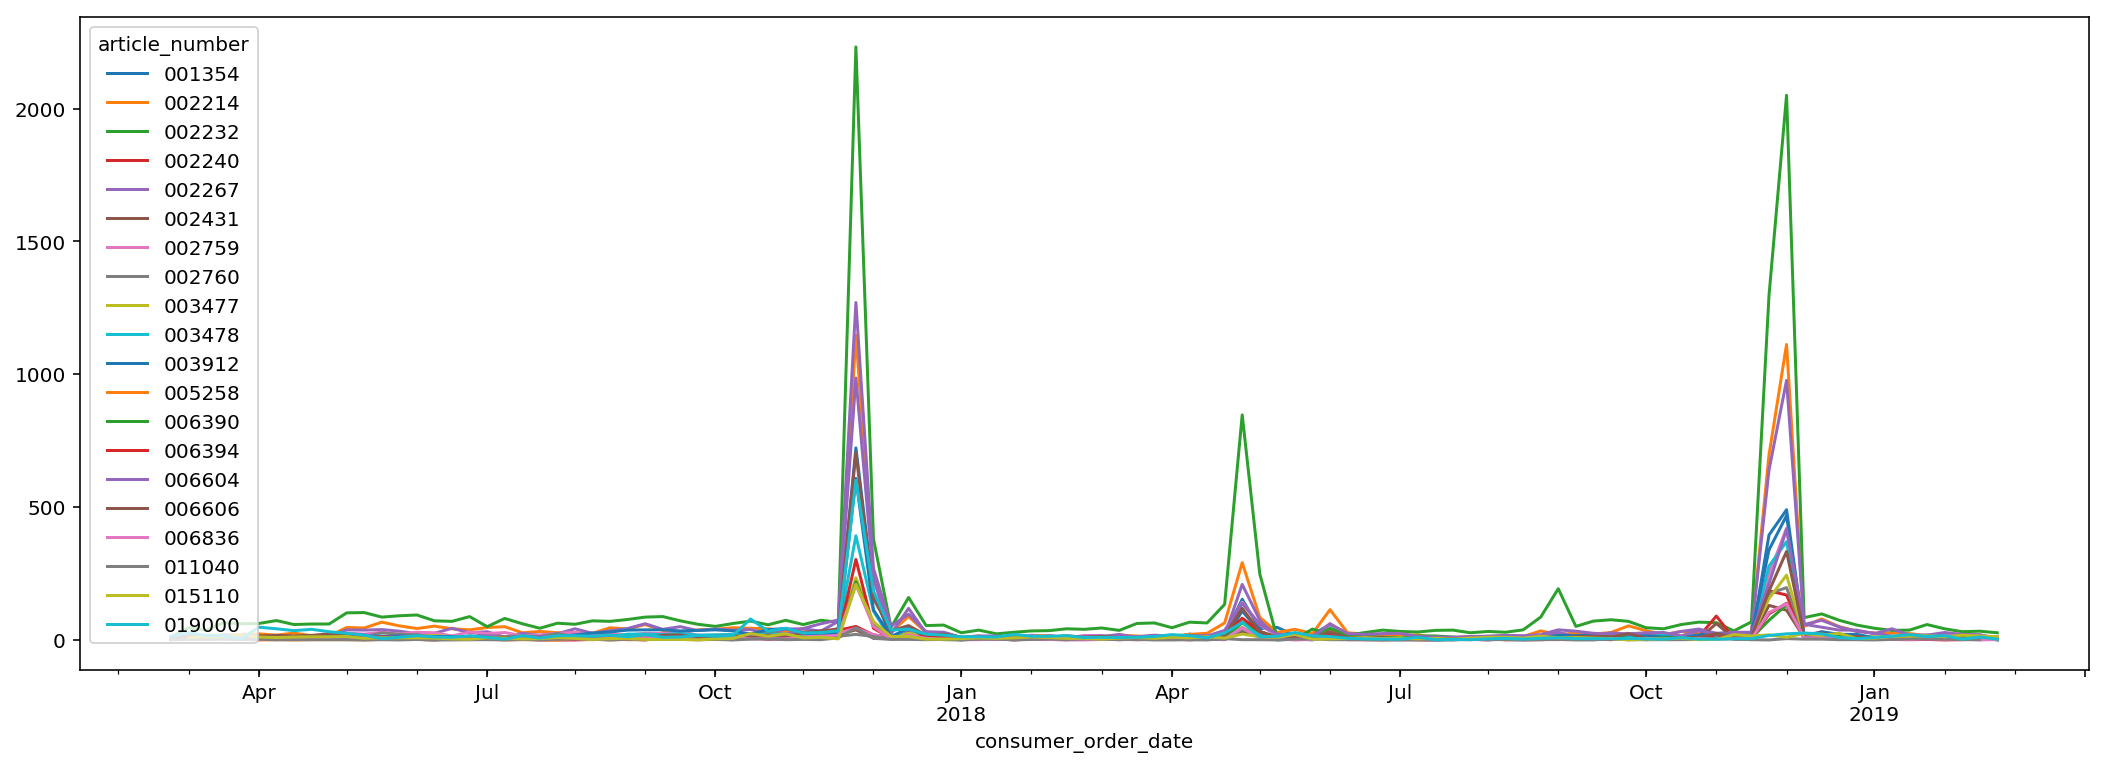

In [110]:
# dat.fillna(value=0, inplace = True) # Define single transaction article std to be 0
plt.rcParams["figure.figsize"] = [18,6]


dat_aggs_pivoted[dat_aggs_pivoted.columns[0:20]].plot()





In [ ]:
# S21490 (arbitrarily) for learning time series EDA

datS21 = (dat_aggs[dat_aggs['article_number'] == 'S21490'].
          set_index('consumer_order_date').
          drop('article_number', axis = 1)
         )

weekly = datS21.resample('W').sum() # 'aggregate' to weekly sums

weekly.head()
weekly.plot()